In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as ss
import os

#variable
SUMMARY = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/LR_SummaryTest_Table.tsv'
TSS = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Merged_Causality_TSS_TSS.tab'
ANNOT =  "/storage/mgymrek/gtex/annotations/encode/"
GENEANNOT='/storage/resources/dbase/human/hg19/gencode_gene_annotations_hg19.csv'
TF_ANNOT = '/storage/mgymrek/gtex/tfbs/encodedata/'
CAUSALSCORES='/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Merged_Best_causality.Table'
ANNOTDIR = "/storage/mgymrek/gtex/annotations/"

SHORTEN = {
    "Artery-Aorta":"Artery.A"     ,
    "Artery-Tibial": "Artery.T",
    "Adipose-Subcutaneous": "Adipose.S",    
    "Adipose-Visceral":"Adipose.V",
    "Brain-Caudate":"Caudate"   , 
    "Brain-Cerebellum":"Cerebellum",
    "Cells-Transformedfibroblasts": "Fibroblast",
    "Esophagus-Mucosa": "Mucosa",
    "Esophagus-Muscularis":"Muscularis",
    "Heart-LeftVentricle":"Heart",
    "Lung": "Lung",
    "Muscle-Skeletal": "Muscle",
    "Nerve-Tibial":"Nerve",
    "Skin-NotSunExposed": "SkinUnexposed",
    "Skin-SunExposed":"SkinLeg",
    "Thyroid":"Thyroid",
    "WholeBlood": "Blood"
}
TISSUES = sorted([item for item in list(SHORTEN.keys()) if item != "permuted"])
COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
    "permuted": "gray"
}

def get_intersect(Path, allstrstested):
    #intersect with strong enhancers
    command = "bedtools intersect -a %s -b %s -wa > Intersect.bed"%(allstrstested,Path)
    value = os.system(command)
    data = pd.read_csv('Intersect.bed', sep='\t', names=["chrom","start","end","gene"]).drop_duplicates()
    feature_loci = set(data.apply(lambda x: x["chrom"]+":"+str(x["start"]), 1))
    return(data, feature_loci)
    

sep='"\t"'
OUTPATH = "../pdfs"
PREFIX = "SupllFigure" # Keep as a variable in case we move things around!

#command = "cat %s |awk -F'\t' '{print $1%s$2%s$75%s$4}' | uniq > all_analyzed_strs.tab"%(SUMMARY, sep,sep,sep)
#value = os.system(command)

In [2]:
#All STRs
allstrs = pd.read_csv(SUMMARY, sep='\t')
allstrs['locus']=allstrs.apply(lambda x: x["chrom"]+":"+str(x["str.start"]), 1)

#  We define causal as eSTRs with higher caviar score than the top 100 SNPs (There are 4482)
#  Also included all eSTRs with caviar score >0.1 even if not top variant

#STRs with caviar scores
Causal = pd.read_csv(CAUSALSCORES, sep='\t')
Causal=Causal[np.isfinite(Causal['best.str.start'])]
Causal['str.start']= Causal['best.str.start'].astype(int)
allstrs=allstrs.merge(Causal, on=['gene','chrom','str.start'], how='left')
allstrs['causal']=allstrs['top.variant'].astype(str).apply(lambda x: 1 if 'STR_' in x else 0)
allstrs.loc[(allstrs['best.score']>0.1), 'causal']=1
ecausal = allstrs.loc[allstrs['causal']==1]
print(allstrs.shape, 'All loci:', len(set(allstrs['locus'])) , ecausal.shape, 'eSTR loci:',len(set(ecausal['locus'])))
allstrstested='all_analyzed_strs.tab'

(307187, 87) All loci: 125758 (4867, 87) eSTR loci: 4613


In [41]:
##==========================Features==============skip this cell for everall evaluation (All STRs)
##                             enhancers
"""
FEATURES = ["Strong_Enhancer","Weak_Enhancer"]
enhancer = {
    'Strong_Enhancer': os.path.join(ANNOT,"%s_GM12878.bed"%FEATURES[0]),
    'Weak_Enhancer': os.path.join(ANNOT,"%s_GM12878.bed"%FEATURES[1])
            }
Path_to_feature = [enhancer[s] for s in FEATURES]
"""
#================================================================
#                              Other features POLR2A TFs

#FEATURES = ['H3K79me2',"H3K4me3","MLLT1","EP300","HCFC1"]
FEATURES = ['POLR2A', "POLR2AphosphoS2","POLR2AphosphoS5"]
Path_to_feature = [os.path.join(TF_ANNOT,"%s_GM12878.bed.gz"%FEATURES[s]) for s in range(len(FEATURES))]

#================================================================
#                             Gene location
"""
geneloc = {
    "introns": os.path.join(ANNOTDIR, "introns.bed"),
    "3'utr": os.path.join(ANNOTDIR, "3utr.bed"),
    "5'utr": os.path.join(ANNOTDIR, "5utr.bed"),
    "Coding (CDS)": os.path.join(ANNOTDIR, "coding.bed")
           }
FEATURES = sorted(geneloc.keys())
Path_to_feature = [geneloc[FEATURES[s]] for s in range(len(FEATURES))]
"""
##
#================================================================

s=0
for F in Path_to_feature:
    feature=FEATURES[s]
    intersect,feature_loci = get_intersect(F, allstrstested)
    allstrs[feature] = np.where(allstrs["locus"].isin(feature_loci), 1, 0)
    s=s+1 

In [7]:
#choose feature and get intersection
#Change field name

feature="All_causal"
feature_set=allstrs.loc[allstrs['E.tissues']>=0]

#feature="Enhancers"                 
#feature_set = allstrs.loc[((allstrs[FEATURES[0]]==1)|allstrs[FEATURES[1]]==1)].copy()

#feature="all POLR2A state"                 
#feature_set = allstrs.loc[((allstrs[FEATURES[0]]==1)|allstrs[FEATURES[1]]==1)|(allstrs[FEATURES[2]]==1)].copy()

#feature = FEATURES[3]         
#feature_set = allstrs.loc[allstrs[feature]==1].copy()
#print(feature,feature_set.shape, len(set(feature_set['locus'])),' STRs loci present')
print('%s causal estrs loci in %s'%(str(len(set(feature_set.loc[feature_set['causal']>0]['locus']))), feature))

4613 causal estrs loci in All_causal


In [4]:
#Evaluating overall enrichment

causal_feature = feature_set.loc[feature_set['causal']==1].copy()
motif_list = list(set(causal_feature['motif']))
print('%s motifs total'%len(motif_list))
locus=len(set(allstrs['locus']))
num_causal=len(set(ecausal['locus']))
locus_feature = len(set(feature_set['locus']))
estr_enh_locus = len(set(causal_feature['locus']))  

odds=[]
pval=[]
count=[]
Motifs=[]

#overall enrichment #66 causal motifs     A=motif  B=causal  n=non
for motif in motif_list:
    AB = len(set(causal_feature.loc[causal_feature['motif']==motif]["locus"]))
    #if AB < 10:
        #print(motif,AB)
    #    continue
    AnB= len(set(causal_feature["locus"])) - AB
    nAB= len(set(feature_set.loc[feature_set['motif']==motif]["locus"]))- AB
    nAnB= locus_feature-len(set(feature_set.loc[feature_set['motif']==motif]['locus']))-(AnB) 
    #print([me,mne],[nme,nmne])    
    OR, p = ss.fisher_exact([[AB,AnB],[nAB,nAnB]])
    
    odds.append(np.log2(OR))
    pval.append(p) #(-np.log10(p))
    count.append((len(set(feature_set.loc[feature_set['motif']==motif]['locus'])), AB))
    Motifs.append(motif)

data1=pd.DataFrame.from_dict({'motif':Motifs, 'OR':odds, 'pvalue':pval, 'Counts':count}).sort_values('pvalue')
data1.index=list(data1['motif'])
print(data1.shape, len(motif_list))
data1.head(5)

93 motifs total
(93, 4) 93


,Counts,OR,motif,pvalue
CCG,"(196, 24)",1.879059,CCG,2.853529e-07
AG,"(4351, 111)",-0.556806,AG,3.288408e-05
CCCCG,"(36, 8)",2.909701,CCCCG,3.925481e-05
CCCCCG,"(23, 6)",3.214061,CCCCCG,1.429486e-04
AAAT,"(6732, 294)",0.278388,AAAT,2.157545e-03


In [6]:
#Evaluating enrichment in tissues

data = data1.copy()

Num=0
for T in TISSUES:
    caviar = pd.read_csv('/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/%s/HH/CAVIAR_wg.csv'%T, sep='\t')
    caviar['str.start']=caviar['top_str'].apply(lambda x: int(x.split('_')[1]))
    caviar['locus']=caviar.apply(lambda x: x["CHROM"]+":"+str(x["str.start"]), 1)
    locus=len(set(caviar.loc[(caviar['top_snp_score']<=caviar['top.str.score'])|(caviar['top.str.score']>0.1)]['locus']))    
    caviar = caviar.merge(feature_set, on=['locus', 'gene'], how='left').copy()    
    causal_feature = caviar.loc[(caviar['top_snp_score']<=caviar['top.str.score'])|(caviar['top.str.score']>0.1)]
    
    num_causal=len(set(ecausal['locus']))
    locus_feature = len(set(feature_set['locus']))
    estr_enh_locus = len(set(causal_feature['locus']))  
    odds=[]
    pval=[]
    count=[]
    colors=[]
    alpha=0.05/(len(list(data['motif'])) - 40)
    for motif in list(data['motif']):
        me = len(set(causal_feature.loc[causal_feature['motif']==motif]['locus']))
        if me==0:
            odds.append(0); Num=Num+1
            pval.append(1)
            colors.append('white')
            count.append((feature_set.loc[feature_set['motif']==motif].shape[0], me))
            continue
            
        mne= estr_enh_locus - me
        nme= len(set(feature_set.loc[feature_set['motif']==motif]['locus']))-me  #len(set(feature_set.loc[feature_set['motif']==motif]['locus']))
        nmne=locus_feature-(nme+me)-(mne) 
        OR, p = ss.fisher_exact([[me,mne],[nme,nmne]])
        odds.append(np.log2(OR))
        pval.append(p) #(-np.log10(p))
        count.append((nme+me, me))
        if (OR>1 and p<alpha) : colors.append(COLORS[T])               #alpha is corrected
        else:  colors.append('white')

#        if motif=='AGAT':
#        print(motif,': ',me, ' P(OR)',p,'(',OR,')','...',SHORTEN[T])
    D=pd.DataFrame.from_dict({'motif':Motifs, 'OR':odds, 'pvalue':pval, 'Counts':count})
    D.index=list(D['motif'])
    D['color']= colors
    data[SHORTEN[T]] = colors
    #print(data.loc['AGAT',:])
    
data2=data.copy()
print(Num, alpha, data.shape)
#data.head(5) 

981 0.0009433962264150943 (93, 21)


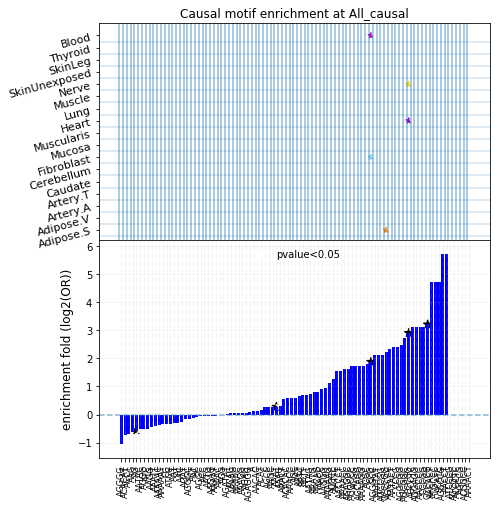

In [8]:
# Plotting enrichment
data=data2.copy()
data=data.sort_values('OR',ascending=True)
X=[i for i in range(data.shape[0])]

fig = plt.figure(figsize=(7,8))
plt.subplots_adjust( hspace=0)
#Tissues
bx = fig.add_subplot(211)

Num=0
for i in range(len(TISSUES)):
    T=TISSUES[i]
    Num = Num +1
    Y=[Num]*data.shape[0]
    #plt.axhline(y=Num, xmin=0, xmax=1, hold=None, alpha=0.25, ls='--')
    bx.scatter(X, Y, color=list(data[SHORTEN[T]]), marker='*')
    
plt.title("Causal motif enrichment at %s"%feature)    
bx.set_yticks([i for i in range(1,len(TISSUES)+1,1)])
bx.set_yticklabels([SHORTEN[T] for T in TISSUES], size=11, rotation=15);
plt.setp(bx.get_xticklabels(), visible=False)
for i in range(data.shape[0]):  plt.axvline(x=i-0.5, ymin=0, ymax=1, hold=None, alpha=0.5, ls='-')
for i in range(len(TISSUES)): plt.axhline(y=i+0.5, xmin=0, xmax=1, hold=None, alpha=0.2, ls='-')
#bx.grid()

#summary
data['color']= data['pvalue'].apply(lambda x: 'black' if x<=0.05/17 else 'white')        #alpha=0.05/17

ax = fig.add_subplot(212,sharex=bx)
ax.bar(X,data['OR'], color='b')
ax.scatter(X, list(data['OR']), color=list(data['color']), marker='*', s=80, label='pvalue<0.05')

ax.set_xticks(X)
ax.set_xticklabels(list(data.index), size=8, rotation='vertical');
ax.set_ylabel("enrichment fold (log2(OR))", size=12)
ax.grid(linestyle='--', alpha=0.2)
ax.legend(loc="upper center", frameon=False);
plt.axhline(y=np.log2(1), xmin=0, xmax=1, hold=None, alpha=0.5, ls='--')
plt.show()
fig.savefig(os.path.join(OUTPATH,'%s_causal_motif_enrichment_%s.pdf'%(PREFIX, feature) ))

In [14]:
P = data[['Counts','OR','pvalue']].copy()
P['Total'] = P['Counts'].apply(lambda x: x[1], 1)
P['motif'] = P.index
#P[['Total','OR', 'pvalue']].sort_values('pvalue').to_csv('/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/CAUSAL_ENRICHMENT_TABLE.csv')
P

,Counts,OR,pvalue,Total,motif
AGGGG,"(56, 1)",-1.066816,7.245241e-01,1,AGGGG
ACACAT,"(44, 1)",-0.711578,1.000000e+00,1,ACACAT
ACCT,"(43, 1)",-0.677619,1.000000e+00,1,ACCT
AAG,"(292, 7)",-0.633785,3.462789e-01,7,AAG
AG,"(4351, 111)",-0.556806,3.288408e-05,111,AG
AATAC,"(39, 1)",-0.533182,1.000000e+00,1,AATAC
AGGG,"(270, 7)",-0.517623,4.192265e-01,7,AGGG
ATC,"(535, 14)",-0.504732,2.471635e-01,14,ATC
AAGG,"(839, 23)",-0.436517,1.666862e-01,23,AAGG
AAATT,"(71, 2)",-0.393835,1.000000e+00,2,AAATT


In [ ]:
Pe = pd.read_csv('/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/ESTR_ENRICHMENT_TABLE.csv')
Pe.columns=['motif','Total','OR','pvalue']
Pc = P[['motif','Total','OR','pvalue']]

Pe.merge(Pc, on=['motif'], how='inner').sort_values('motif', ascending=False).to_csv('/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/ENRICHMENT_TABLE.csv', index=None)